In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import splitfolders
import PIL
import pandas as pd
import scipy


# Import Keras
import keras as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras import optimizers
from keras.optimizers import Adam
from keras.applications import Xception
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Vérification des images + Création des dataset de train et de test

def verification_and_split(path_to_image,output): 
    for subdir,_, files in os.walk(path_to_image):
        for file in files :
            filepath= os.path.join(subdir, file)
            try:
                with PIL.Image.open(filepath) as img:
                    img.verify()
            except(IOError, SyntaxError,PIL.UnidentifiedImageError):
                print(f"Suppresion de {filepath}")
                os.remove(filepath)
    # Diviser le dossier 'Images' avec un ratio de 90% pour l'entraînement (incluant la validation) et 10% pour les tests
    splitfolders.ratio(path_to_image, output=output, seed=42, ratio=(.9, .1), group_prefix=None)
    os.rename('data_splits/val', 'data_splits/test')

In [6]:
verification_and_split('Images', 'data_splits')

In [ ]:
def create_generator(batch): 
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)  # Réserver 20% des données pour la validation

    # Créer le générateur pour l'entraînement
    train_generator = train_datagen.flow_from_directory(
        "data_splits/train",
        target_size=(255, 255),
        batch_size=batch,
        class_mode='categorical',
        subset='training')  # Utiliser la partie 'training' du dataset

    # Créer le générateur pour la validation
    validation_generator = train_datagen.flow_from_directory(
        "data_splits/train",
        target_size=(255, 255),
        batch_size=batch,
        class_mode='categorical',
        subset='validation')
    
    #Pareil pour le test
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
    "data_splits/test",  
    target_size=(255, 255), 
    batch_size=batch,
    class_mode='categorical',
    shuffle=False) 



    return train_generator, validation_generator,test_generator

# Fonction pour envelopper votre générateur et ajouter un logging
def generator_with_logging(generator):
    for batch_x, batch_y in generator:
        # Log l'index du batch actuel et le ou les noms de fichiers correspondants
        file_index = generator.batch_index * generator.batch_size
        # Assurez-vous de ne pas dépasser le nombre de fichiers
        file_index = file_index % len(generator.filenames)
        batch_files = generator.filenames[file_index:file_index + generator.batch_size]
        print(f"Chargement du batch d'images: {batch_files}")
        yield batch_x, batch_y


# Visualisation de deux images du générateur avec logging
def visualisation(id_im,generator_w_logging): 
    try:
        x, y = next(generator_w_logging)  # Utilisez le générateur avec logging

        for i in range(id_im, id_im+2):
            image = x[i]
            plt.imshow(image)
            plt.title(y[i].argmax())
            plt.show()
    except Exception as e:
        print(f"Une erreur est survenue: {e}")



Found 14816 images belonging to 120 classes.
Found 3654 images belonging to 120 classes.
Found 2110 images belonging to 120 classes.
Chargement du batch d'images: ['n02085620-Chihuahua\\n02085620_2650.jpg', 'n02085620-Chihuahua\\n02085620_2693.jpg', 'n02085620-Chihuahua\\n02085620_2706.jpg', 'n02085620-Chihuahua\\n02085620_275.jpg', 'n02085620-Chihuahua\\n02085620_2815.jpg', 'n02085620-Chihuahua\\n02085620_2903.jpg', 'n02085620-Chihuahua\\n02085620_2937.jpg', 'n02085620-Chihuahua\\n02085620_2973.jpg', 'n02085620-Chihuahua\\n02085620_3006.jpg', 'n02085620-Chihuahua\\n02085620_3033.jpg', 'n02085620-Chihuahua\\n02085620_3045.jpg', 'n02085620-Chihuahua\\n02085620_3093.jpg', 'n02085620-Chihuahua\\n02085620_3110.jpg', 'n02085620-Chihuahua\\n02085620_3208.jpg', 'n02085620-Chihuahua\\n02085620_326.jpg', 'n02085620-Chihuahua\\n02085620_3407.jpg']


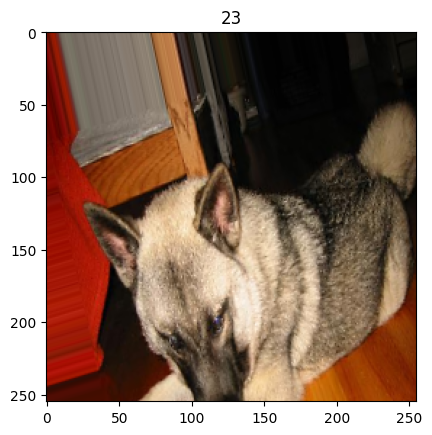

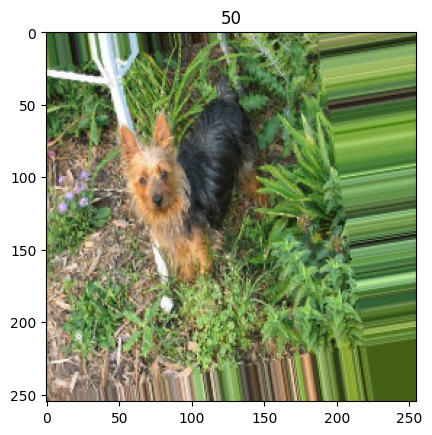

In [ ]:
generator = create_generator(16) 
train_generator_with_logging = generator_with_logging(generator[0])
validation_generator_with_logging = generator_with_logging(generator[1])
visualisation(3,train_generator_with_logging)


In [16]:
def neural_net(num_neurones,num_hidden_layers,dropout_rate, early_stop_patience, lr_scheduler_patience, learning_rate= 0.0001):
    # Charger le modèle Xception pré-entraîné
    base_model = Xception(weights='imagenet', include_top=False)

    # Ajouter des couches personnalisées
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Ajouter Global Average Pooling pour réduire la dimensionnalité
    for _ in range (0, num_hidden_layers): 
        x = Dense(num_neurones, activation='relu')(x)  # Ajouter une couche Dense pour l'apprentissage des caractéristiques
        x = Dropout(dropout_rate)(x)  # Ajouter une couche de dropout pour réduire le surapprentissage
    predictions = Dense(120, activation='softmax')(x)  # Couche de sortie pour 120 classes

    # Configurer les callbacks
    checkpoint = ModelCheckpoint("test.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stop_patience, verbose=1, mode='auto')
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=lr_scheduler_patience)
    callbacks = [checkpoint, early, lr_scheduler]

    # Créer l'instance de l'optimiseur avec le learning rate spécifié
    optimizer = Adam(learning_rate=learning_rate)

    # Compiler le modèle avec l'optimiseur configuré
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model, callbacks

# Entraîner le modèle
def train(model, cb, generator, n_epoch):
    history = model.fit(
        generator[0],
        steps_per_epoch=generator[0].samples/generator[0].batch_size,
        epochs=n_epoch,
        validation_data=generator[1],
        validation_steps=generator[1].samples/generator[1].batch_size,
        callbacks=cb)
    
    model.save('test_final.h5')
    return history

def plot_history(history):
    # Tracer la précision et la perte
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()




Epoch 1/200
926/926 [==============================] - ETA: 0s - loss: 2.2772 - accuracy: 0.4678
Epoch 1: val_loss improved from inf to 0.86362, saving model to test.h5
926/926 [==============================] - 336s 357ms/step - loss: 2.2772 - accuracy: 0.4678 - val_loss: 0.8636 - val_accuracy: 0.7455 - lr: 1.0000e-04
Epoch 2/200
926/926 [==============================] - ETA: 0s - loss: 0.9468 - accuracy: 0.7293
Epoch 2: val_loss improved from 0.86362 to 0.79291, saving model to test.h5
926/926 [==============================] - 310s 335ms/step - loss: 0.9468 - accuracy: 0.7293 - val_loss: 0.7929 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 3/200
926/926 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.7981
Epoch 3: val_loss improved from 0.79291 to 0.70489, saving model to test.h5
926/926 [==============================] - 309s 334ms/step - loss: 0.6869 - accuracy: 0.7981 - val_loss: 0.7049 - val_accuracy: 0.7956 - lr: 1.0000e-04
Epoch 4/200
926/926 [========

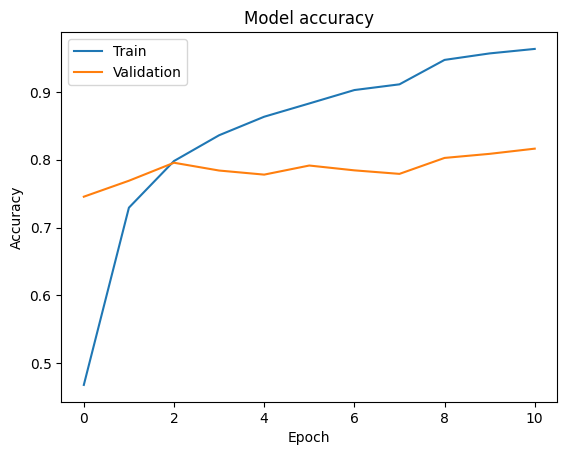

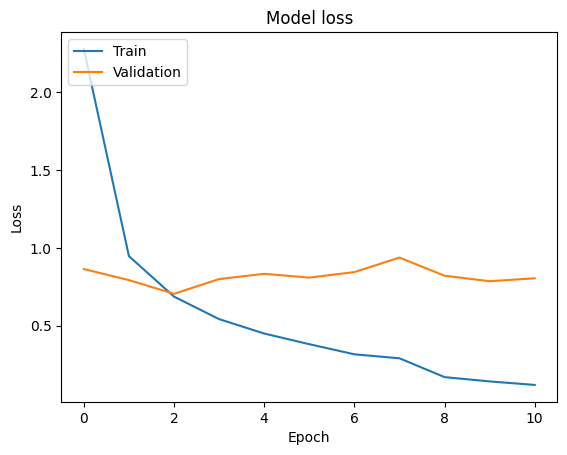

In [ ]:
model, callback = neural_net(num_neurones=512, num_hidden_layers=2, 
                              dropout_rate=0.3, early_stop_patience=8, 
                              lr_scheduler_patience=5, learning_rate= 0.0001)

history = train(model=model, cb= callback, 
                  generator= generator, n_epoch=200)

plot_history(history=history)

In [ ]:
def predict_test(path_to_model, test_generator):
    ## Charger le modèle
    model = load_model(path_to_model)  

    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

    # Évaluer le modèle
    scores = model.evaluate(test_generator, steps=test_steps_per_epoch)
    return scores


In [ ]:
predict_test('test.h5', generator[2])

132/132 [==============================] - 9s 61ms/step - loss: 0.6652 - accuracy: 0.8100
Accuracy sur le test set:  0.8099526166915894
132/132 [==============================] - 8s 59ms/step
None
